In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.models as models
from torch.utils.data import DataLoader
from foolbox.models import PyTorchModel

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [3]:
def get_mean_std(dataloader, c):
    ''' Computes mean and standard deviation from a dataloader (training set 
    is prefered),
    '''
    assert isinstance(dataloader, DataLoader)
    
    n = torch.zeros(1)
    mean = torch.zeros(c)
    std = torch.zeros(c)

    for bx, _ in dataloader:
        b, c, _, _ = bx.size()  # last batch has fewer images
        n += b
        bx = bx.view(b, c, -1)
        mean += bx.mean(2).sum(0)
        std += bx.std(2).sum(0)
    
    print('# of samples in dataloader', n.item())
    mean = (mean / n).numpy()
    std = (std / n).numpy()
    return mean, std

In [4]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [5]:
root = os.path.join('.', 'dataset_root')
print(f'Path directory: {root}')
batch_size = 128

Path directory: ./dataset_root


In [6]:
cifar_train = tv.datasets.CIFAR10(
    root,
    train=True,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor()]))
dataloader_cifar_train = DataLoader(
    cifar_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers)

mean, std = get_mean_std(dataloader_cifar_train, 3)
print(mean, std)

cifar_train = tv.datasets.CIFAR10(
    root,
    train=True,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)]))
dataloader_cifar_train = DataLoader(
    cifar_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers)

cifar_test = tv.datasets.CIFAR10(
    root,
    train=False,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)]))
dataloader_cifar_test = DataLoader(
    cifar_test,
    batch_size,
    shuffle=True,
    num_workers=num_workers)

n_train = len(dataloader_cifar_train.dataset)
n_test = len(dataloader_cifar_test.dataset)
print(f'Train = {n_train}, Test = {n_test}')

classes = np.array(['plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'])
print(f'# of classes {len(classes)}')

Files already downloaded and verified
# of samples in dataloader 50000.0
[0.49139997 0.48215854 0.4465308 ] [0.20230092 0.19941273 0.20096155]
Files already downloaded and verified
Files already downloaded and verified
Train = 50000, Test = 10000
# of classes 10


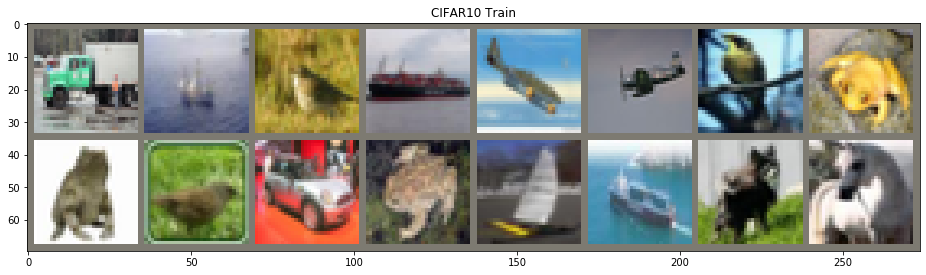

truck, ship, bird, ship, plane, plane, bird, frog
frog, bird, car, frog, ship, ship, dog, horse


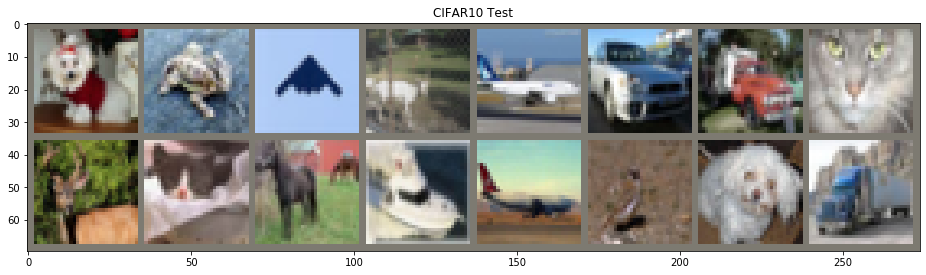

dog, frog, plane, deer, plane, car, truck, cat
deer, cat, horse, ship, plane, bird, dog, truck


In [7]:
images, labels = next(iter(dataloader_cifar_train))
plt.figure(figsize=[16,8])
imshow(images[:16], mean=mean, std=std, title='CIFAR10 Train')
plt.show()
print(*classes[labels[:8].numpy()], sep=', ')
print(*classes[labels[8:16].numpy()], sep=', ')

images, labels = next(iter(dataloader_cifar_test))
plt.figure(figsize=[16,8])
imshow(images[:16], mean=mean, std=std, title='CIFAR10 Test')
plt.show()
print(*classes[labels[:8].numpy()], sep=', ')
print(*classes[labels[8:16].numpy()], sep=', ')

In [24]:
resnet18 = models.resnet18(pretrained=True)

In [25]:
num_fc_in = resnet18.fc.in_features
print(num_fc_in)

resnet18.fc = nn.Linear(num_fc_in, len(classes))
# resnet18 = resnet18.to(device)

softmax_model = nn.Sequential(
    resnet18,
    nn.Softmax(10))
softmax_model = softmax_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(softmax_model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

512


In [26]:
def train(model, loader):
    model.train()
    running_loss = 0.
    correct = 0
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)  # last batch could be smaller
        
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        exp_lr_scheduler.step()
        
        # for display
        running_loss += loss.item() * batch_size
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()
    
    running_loss = running_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return running_loss, accuracy

In [27]:
def test(model, loader):
    with torch.no_grad():
        model.eval()
        running_loss = 0
        correct = 0

        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)  # last batch could be smaller
            
            output = model(x)
            loss = loss_fn(output, y)
            
            running_loss += loss.item() * batch_size
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
            
        running_loss /= len(loader.dataset)
        accuracy = correct/len(loader.dataset)
    return running_loss, accuracy

In [28]:
for epoch in range(5):
    start = time.time()
    train_loss, train_acc = train(resnet18, dataloader_cifar_train)
    test_loss, test_acc = test(resnet18, dataloader_cifar_test)
    time_elapsed = time.time() - start
    print(('Epoch: {} - {:.0f}m {:.1f}s. Train loss:{:.4f}, accuracy: {:.4f}. '+ \
          'Test loss:{:.4f}, accuracy: {:.4f}').format(
        epoch+1,
        time_elapsed//60,
        time_elapsed%60,
        train_loss,
        train_acc,
        test_loss,
        test_acc))

Epoch: 1 - 0m 12.7s. Train loss:1.7782, accuracy: 0.3898. Test loss:1.7634, accuracy: 0.3970
Epoch: 2 - 0m 12.4s. Train loss:1.7556, accuracy: 0.3991. Test loss:1.7633, accuracy: 0.3994
Epoch: 3 - 0m 12.9s. Train loss:1.7538, accuracy: 0.3979. Test loss:1.7638, accuracy: 0.3971
Epoch: 4 - 0m 13.0s. Train loss:1.7534, accuracy: 0.3998. Test loss:1.7572, accuracy: 0.3980
Epoch: 5 - 0m 12.4s. Train loss:1.7530, accuracy: 0.3996. Test loss:1.7687, accuracy: 0.3978


## TODO
